In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
import datetime
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from linearmodels.panel import PanelOLS

old_data_folder = '/Users/simonneumeyer/Dropbox/DO-FILES/data/'


Bad key "text.kerning_factor" on line 4 in
/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data = pd.read_parquet('../../data/output/loan_level.pq', engine='pyarrow')
data_collapsed = pd.read_parquet('../../data/output/firm_year_level.pq', engine='pyarrow')
prod_for_tfp = pd.read_stata(old_data_folder + "/Kosovo Tax Registry/productivity_for_tfp.dta")
tax_data = pd.read_stata(old_data_folder + 'Kosovo Tax Registry/taxregistry_descriptive.dta')

In [3]:
#data_collapsed.sort_values(['fuid', 'period'])

# Descriptive Stats:

In [6]:
data['credit'] = (data.approvedamount_eu > 0).map(int)

In [7]:
data.credit.value_counts()

1    158929
0      3688
Name: credit, dtype: int64

## Number of loans per firm

In [8]:
loan_counts = data.groupby('fuid')['credit'].sum()

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


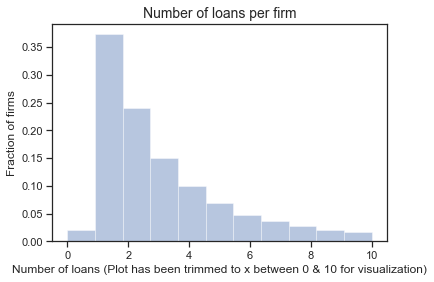

In [9]:
sns.set(style="ticks")
sns.distplot(loan_counts, 
             bins=11, 
             hist_kws={'range': (0.0, 10.0)},
             #kde_kws={'clip': (0.0, 9.0)},
             kde=False, 
             norm_hist=True,
            )
plt.title('Number of loans per firm',fontsize=14)
plt.xlabel(f'Number of loans (Plot has been trimmed to x between 0 & 10 for visualization)')
plt.ylabel('Fraction of firms')
plt.savefig('../../data/output/graphs/number_of_loans.png')
plt.show()

In [44]:
data.groupby('fuid').size().median()

2.0

In [42]:
#data.groupby('fuid').size().median()

In [43]:
data.fuid.value_counts()

29854182.0    6927
29887946.0    3878
29843414.0    2350
29889001.0    1976
29886685.0    1055
              ... 
29871640.0       1
29932681.0       1
29889982.0       1
29932785.0       1
29884411.0       1
Name: fuid, Length: 28940, dtype: int64

## Average loan amount (you could plot the kernel density with the reference line crossing the mean or median of the loan amount distribution)

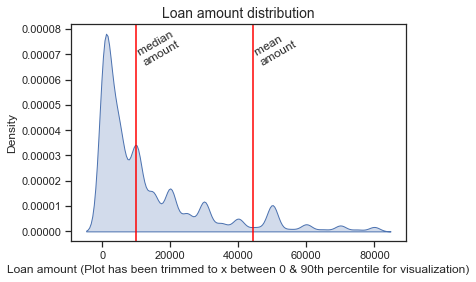

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


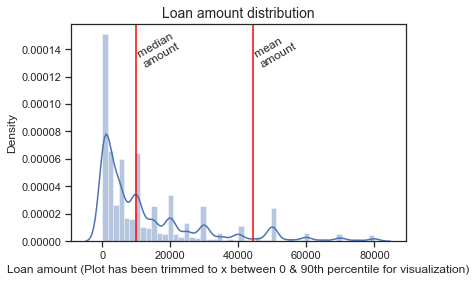

In [7]:
# prepare data
loanamount = data.approvedamount_eu.fillna(0)
mean_amount = loanamount.mean()
median_amount = loanamount.median()
q_90 = loanamount.quantile(0.90)
data_trimmed = loanamount[loanamount <= q_90]

# plot
fig = sns.kdeplot(data_trimmed,
                  shade=True,
                 )
ylim = fig.get_ylim()[1]
plt.axvline(mean_amount, 0, 1, c='red')
plt.text(mean_amount, 0.8*ylim, 'mean \namount', rotation=30)
plt.axvline(median_amount, 0, 1, c='red')
plt.text(median_amount, 0.8*ylim, 'median \namount', rotation=30)
plt.title('Loan amount distribution', fontsize=14)
plt.xlabel('Loan amount (Plot has been trimmed to x between 0 & 90th percentile for visualization)')
plt.ylabel('Density')
plt.savefig('../../data/output/graphs/loan_amount.png')
plt.show()

fig_2 = sns.distplot(data_trimmed, 
             #bins=11, 
             #hist_kws={'range': (0.0, 10.0)},
             #kde_kws={'clip': (0.0, 9.0)},
             kde=True, 
             #norm_hist=True,
            )

ylim = fig_2.get_ylim()[1]
plt.axvline(mean_amount, 0, 1, c='red')
plt.text(mean_amount, 0.8*ylim, 'mean \namount', rotation=30)
plt.axvline(median_amount, 0, 1, c='red')
plt.text(median_amount, 0.8*ylim, 'median \namount', rotation=30)
plt.title('Loan amount distribution', fontsize=14)
plt.xlabel('Loan amount (Plot has been trimmed to x between 0 & 90th percentile for visualization)')
plt.ylabel('Density')
plt.savefig('../../data/output/graphs/loan_amount_w_bins.png')
plt.show()

## Share of firms with due outstanding loans (e.g. PAR > 30 days)

In [8]:
# share of firms with outstanding balance:
outstandingamount = data_collapsed.dropna(subset=['fuid'], axis=0)
outstandingamount = outstandingamount[['fuid', 'outstandingbalance', 'period']].fillna(0)
#outstandingamount.groupby('fuid').outstandingbalance.sum()

In [9]:
outstandingamount = outstandingamount[outstandingamount.period==2018]

In [10]:
outstandingamount['outstanding'] = (outstandingamount.outstandingbalance > 0).map(int)

In [11]:
outstandingamount.outstanding.value_counts(normalize=True)

0    0.823446
1    0.176554
Name: outstanding, dtype: float64

## Sector Distribution

In [12]:
#prod_for_tfp[['fuid', 'period','manufacturing', 'utilities', 'construction', 
#              'trade', 'transport', 'hotelsfood', 'communications', 
#              'financial', 'professional', 'services', 'allsectors']]

In [13]:
#prod_for_tfp[['period', 'fuid'] + industry_cols].loc[(prod_for_tfp.hotelsfood==1) & (prod_for_tfp.services==1)]

In [14]:
industry_cols = ['manufacturing', 'utilities', 'construction', 'trade', 'transport', 'hotelsfood', 
                 'communications', 'financial', 'professional', 'services']

df_temp = prod_for_tfp[['period', 'fuid'] + industry_cols].set_index(['period', 'fuid'])
df_temp = df_temp[df_temp==1].stack().reset_index().drop(0, axis=1).rename(columns={'level_2': 'industry'})

df_temp = data_collapsed.merge(df_temp, how='left', on=['period', 'fuid'], validate='one_to_many')

industry_comp = df_temp['industry'].value_counts(normalize=True)
industry_comp = industry_comp.reset_index().rename(columns={'industry': 'Fraction', 'index': 'Industry'})

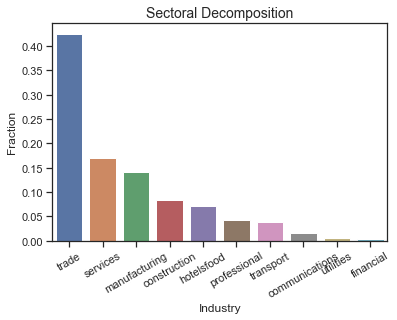

In [15]:
sns.barplot(data=industry_comp, x='Industry', y='Fraction')
plt.xticks(rotation=30)
plt.title('Sectoral Decomposition', fontsize=14)
plt.savefig('../../data/output/graphs/sectoral_decomposition.png')
plt.show()

## Firm's age:

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


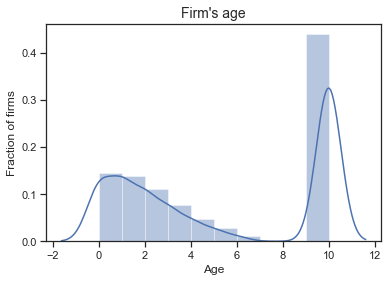

In [16]:
sns.set(style="ticks")
sns.distplot(data_collapsed.age, 
             bins=10, 
             #hist_kws={'range': (0.0, 10.0)},
             #kde_kws={'clip': (0.0, 9.0)},
             #kde=False, 
             norm_hist=False,
            )
plt.title("Firm's age", fontsize=14)
plt.xlabel("Age")
plt.ylabel('Fraction of firms')
plt.savefig('../../data/output/graphs/firm_age.png')
plt.show()

In [17]:
#data_collapsed.age.value_counts()

## interest rates

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


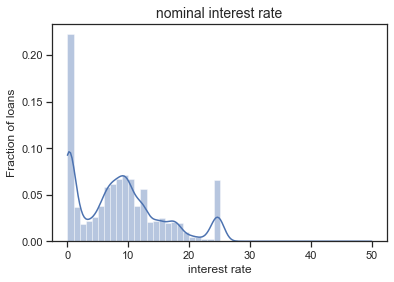

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


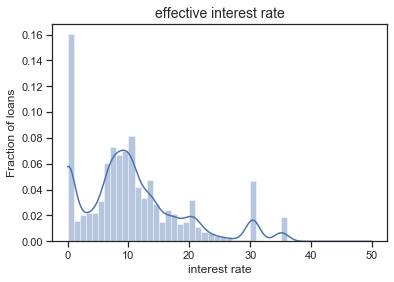

In [18]:
rates = data_collapsed[['irate_nominal', 'irate_effec']]
#nominal = data_collapsed.irate_nominal
rates = rates.rename(columns={'irate_nominal': 'nominal_interest_rate', 'irate_effec': 'effective_interest_rate'})


sns.set(style="ticks")
for col in ['nominal_interest_rate', 'effective_interest_rate']:
    sns.distplot(rates[col], 
                 #bins=15, 
                 hist_kws={'range': (0.0, 50.0)},
                 kde_kws={'clip': (0.0, 50.0)},
                 #kde=False, 
                 norm_hist=False,
                )
    plt.title(col.replace("_", " "), fontsize=14)
    plt.xlabel("interest rate")
    plt.ylabel('Fraction of loans')
    plt.savefig(f'../../data/output/graphs/{col}.png')
    plt.show()

# Correlate firm characteristics:

In [19]:
#import os
#import sys
#sys.path.insert(1, os.path.join(sys.path[0], '..'))
#import matplotlib.axes
#import binscatter
##import pandas as pd
##import numpy as np
#from matplotlib import pyplot as plt

## Create fake data
#n_obs = 1000
#data = pd.DataFrame({"experience": np.random.poisson(4, n_obs) + 1})
#data["Tenure"] = data["experience"] + np.random.normal(0, 1, n_obs)
#data["Wage"] = data["experience"] + data["Tenure"] + np.random.normal(0, 1, n_obs)
#fig, axes = plt.subplots(2, sharex=True, sharey=True)
#
## Binned scatter plot of Wage vs Tenure
#axes[0].binscatter(data["Tenure"], data["Wage"])
#
## Binned scatter plot that partials out the effect of experience
#axes[1].binscatter(
#    data["Tenure"],
#    data["Wage"],
#    controls=data["experience"],
#    recenter_x=True,
#    recenter_y=True,
#)
#axes[1].set_xlabel("Tenure (residualized, recentered)")
#axes[1].set_ylabel("Wage (residualized, recentered)")
#
#plt.tight_layout()
#plt.show()

In [20]:
#age_not_na = data_collapsed[~data_collapsed.age.isna()]
#emp_not_na = data_collapsed[~data_collapsed.employees_tx.isna()]

In [21]:
#fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
#
## Binned scatter plot of Wage vs Tenure
#axes[0].binscatter(age_not_na.credit, age_not_na.age)
#
## Binned scatter plot that partials out the effect of experience
#axes[1].binscatter(
#    emp_not_na.credit,
#    emp_not_na.employees_tx,
##    controls=data["experience"],
#    recenter_x=True,
#    recenter_y=True,
#)
#axes[1].set_xlabel("Credit (residualized, recentered)")
#axes[1].set_ylabel("number of employees (residualized, recentered)")
#
#plt.tight_layout()
#plt.show()

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


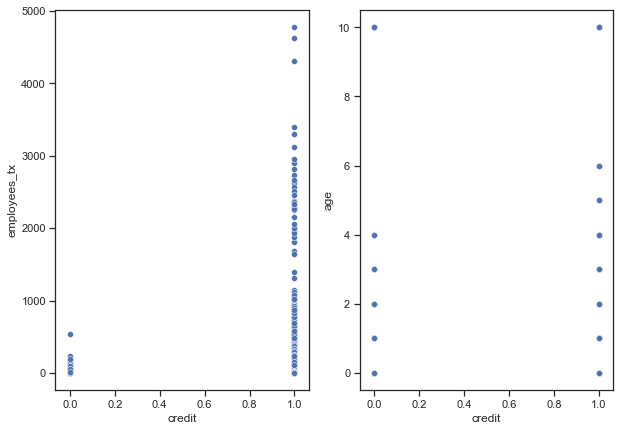

In [22]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,7))

# firm size & credit
sns.scatterplot(data_collapsed.credit, data_collapsed.employees_tx, ax=axes[0])

# firm age & credit
sns.scatterplot(data_collapsed.credit, data_collapsed.age, ax=axes[1])
plt.show()

In [23]:
#sns.regplot(data_collapsed.credit, data_collapsed.employees_tx)
#plt.show()

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 38.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


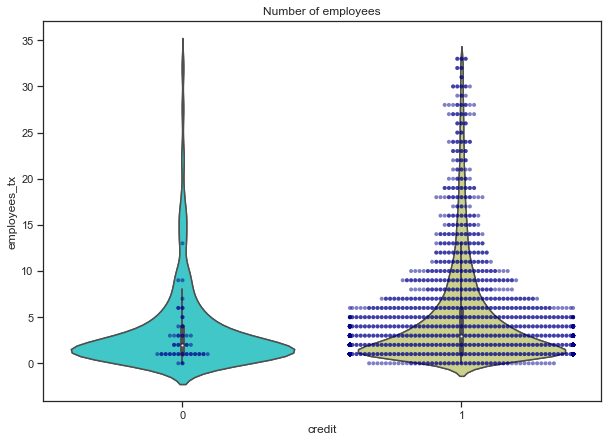

In [24]:
#fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,7))

quantile = data_collapsed.employees_tx.quantile(0.95)
data_collapsed_quantile = data_collapsed[data_collapsed.employees_tx < quantile]

plt.figure(figsize=(10,7))
sns.swarmplot(x='credit', y='employees_tx', data=data_collapsed_quantile.sample(1000), 
              dodge=True, color='darkblue', alpha=.5, s=4)

sns.violinplot(x='credit', y='employees_tx', data=data_collapsed_quantile, dodge=True, palette='rainbow')

sns.swarmplot(x='credit', y='employees_tx', data=data_collapsed_quantile.sample(1000), 
              dodge=True, color='darkblue', alpha=.5, s=4)

sns.violinplot(x='credit', y='employees_tx', data=data_collapsed_quantile, dodge=True, palette='rainbow')
plt.title("Number of employees")
plt.show()

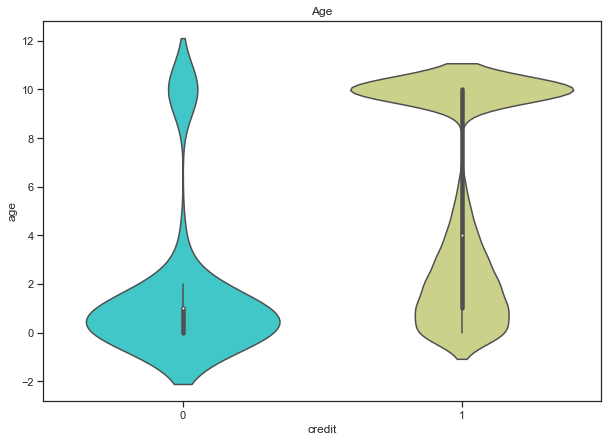

In [25]:
#quantile = data_collapsed.age.quantile(0.95)
#data_collapsed_quantile = data_collapsed[data_collapsed.employees_tx < quantile]

plt.figure(figsize=(10,7))
#sns.swarmplot(x='credit', y='age', data=data_collapsed.sample(1000), 
#              dodge=True, color='darkblue', alpha=.5, s=4)

sns.violinplot(x='credit', y='age', data=data_collapsed, dodge=True, palette='rainbow')
plt.title("Age")
plt.show()

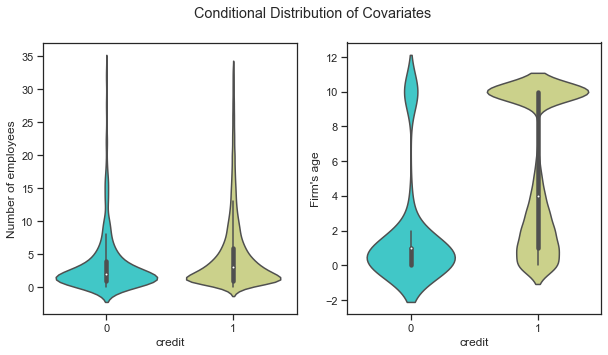

In [26]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))


quantile = data_collapsed.employees_tx.quantile(0.95)
data_collapsed_quantile = data_collapsed[data_collapsed.employees_tx < quantile]


sns.violinplot(x='credit', y='employees_tx', data=data_collapsed_quantile, 
               dodge=True, palette='rainbow', ax=axes[0])
axes[0].set_ylabel('Number of employees')
#plt.title("Number of employees")

sns.violinplot(x='credit', y='age', data=data_collapsed, dodge=True, palette='rainbow', ax=axes[1])
axes[1].set_ylabel("Firm's age")
plt.suptitle("Conditional Distribution of Covariates")
plt.show()

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 61.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


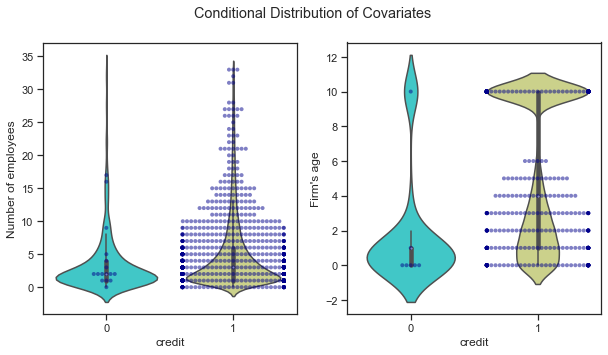

In [27]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))


quantile = data_collapsed.employees_tx.quantile(0.95)
data_collapsed_quantile = data_collapsed[data_collapsed.employees_tx < quantile]


sns.violinplot(x='credit', y='employees_tx', data=data_collapsed_quantile, 
               dodge=True, palette='rainbow', ax=axes[0])
sns.swarmplot(x='credit', y='employees_tx', data=data_collapsed_quantile.sample(1000), 
              dodge=True, color='darkblue', alpha=.5, s=4, ax=axes[0])
axes[0].set_ylabel('Number of employees')

sns.violinplot(x='credit', y='age', data=data_collapsed, dodge=True, palette='rainbow', ax=axes[1])
sns.swarmplot(x='credit', y='age', data=data_collapsed.sample(1000), 
              dodge=True, color='darkblue', alpha=.5, s=4, ax=axes[1])
axes[1].set_ylabel("Firm's age")

plt.suptitle("Conditional Distribution of Covariates")
plt.show()

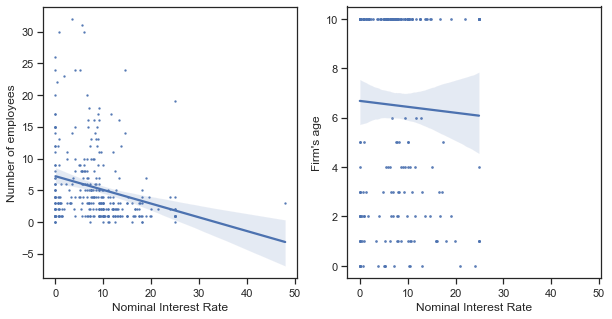

In [28]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))

sns.regplot(x='irate_nominal', y='employees_tx', data=data_collapsed_quantile.sample(1000), 
            ax=axes[0], scatter_kws={'s':2})
sns.regplot(x='irate_nominal', y='age', data=data_collapsed.sample(1000), ax=axes[1], scatter_kws={'s':3})
axes[0].set_ylabel('Number of employees')
axes[1].set_ylabel("Firm's age")
axes[0].set_xlabel('Nominal Interest Rate')
axes[1].set_xlabel('Nominal Interest Rate')
plt.show()

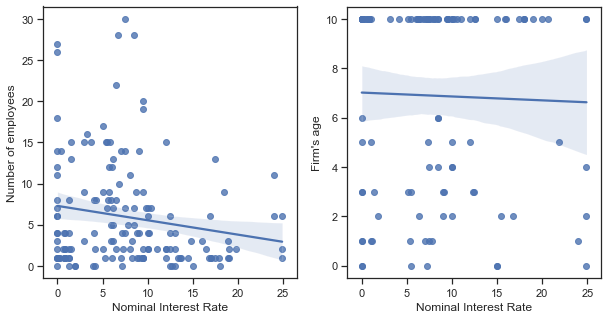

In [29]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))

sns.regplot(x='irate_nominal', y='employees_tx', data=data_collapsed_quantile.sample(500), ax=axes[0])
sns.regplot(x='irate_nominal', y='age', data=data_collapsed.sample(500), ax=axes[1])
axes[0].set_ylabel('Number of employees')
axes[1].set_ylabel("Firm's age")
axes[0].set_xlabel('Nominal Interest Rate')
axes[1].set_xlabel('Nominal Interest Rate')
plt.show()

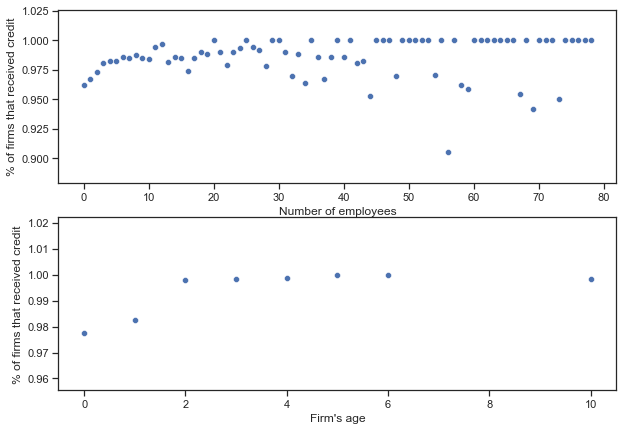

In [30]:
quantile = data_collapsed.employees_tx.quantile(0.98)
data_collapsed_quantile = data_collapsed[data_collapsed.employees_tx < quantile]

age_binned = data_collapsed.groupby('age')['credit'].mean().reset_index()
size_binned = data_collapsed_quantile.groupby('employees_tx')['credit'].mean().reset_index()

# binned by age: scatterplot
fig, axes = plt.subplots(2, 1, sharey=False, figsize=(10,7))

# firm size & credit
sns.scatterplot(data=size_binned, x='employees_tx', y='credit', ax=axes[0])
axes[0].set_xlabel('Number of employees')
axes[0].set_ylabel('% of firms that received credit')

# firm age & credit
sns.scatterplot(data=age_binned, x='age', y='credit', ax=axes[1])
axes[1].set_xlabel("Firm's age")
axes[1].set_ylabel('% of firms that received credit')
plt.show()

In [31]:
data_collapsed.replace(np.inf, np.nan).to_stata('../../data/output/firm_year_level.dta')

# Time series

In [5]:
#data_collapsed['death_month'] = data_collapsed.death_date.dt.month
#data_collapsed['death_year'] = data_collapsed.death_date.dt.year
#
#deaths = data_collapsed.groupby(['death_year', 'death_month']).size().reset_index().rename(columns={0: 'deaths'})
#deaths = deaths.astype(int)
#deaths['death_time'] = deaths.apply(lambda row: datetime.date(year=row.death_year, month=row.death_month, day=1),axis=1)

In [6]:
##data_collapsed.birth_time
#births = data_collapsed.groupby(['birth_time']).size().reset_index().rename(columns={0: 'births'})
#births = births[(births.birth_time.dt.year < 2025) & (births.birth_time.dt.year >= 2009)]

In [8]:
#fig, axes = plt.subplots(5, 1, sharex=False, figsize=(12,9))
#
#sns.lineplot(data=data_collapsed, x='period', y='turnover_tx_r', ax=axes[0])
#axes[0].set_xlabel("Year")
#axes[0].set_ylabel('Sales')
#axes[0].set_title('Average sales over time')
#
#
#sns.lineplot(data=data_collapsed, x='period', y='employees_tx', ax=axes[1])
#axes[1].set_xlabel("Year")
#axes[1].set_ylabel('Number of employees')
#axes[1].set_title('Average number of employees over time')
#
#sns.lineplot(data=data_collapsed, x='period', y='irate_effec', ax=axes[2])
#axes[2].set_xlabel("Year")
#axes[2].set_ylabel('effective interest rate')
#axes[2].set_title('Average effective interest rate over time')
#
#sns.lineplot(data=deaths[deaths.death_year<2100], x='death_time', y='deaths', ax=axes[3])
#axes[3].set_xlabel("time")
#axes[3].set_ylabel('firm deaths')
#axes[3].set_title('Number of firm exits over time')
#
#
#sns.lineplot(data=births, x='birth_time', y='births', ax=axes[4])
#axes[4].set_xlabel("time")
#axes[4].set_ylabel('firm births')
#axes[4].set(ylim=(0, 1000))
#axes[4].set_title('Number of firm entries over time')
#
#plt.savefig(f'../../data/output/graphs/time_series.png')
#
#plt.tight_layout()
#plt.show()

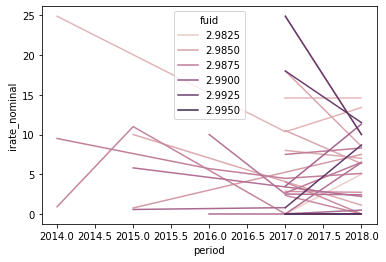

Fraction of participator observations where we have interest rate: 0.06


In [12]:
import random
fuid_list = random.sample(data_collapsed.fuid.unique().tolist(), 500)
sns.lineplot(data=data_collapsed.loc[data_collapsed.fuid.isin(fuid_list)], x='period', y='irate_nominal', hue='fuid')
plt.show()

is_rate = data_collapsed[~data_collapsed.irate_nominal.isna()].shape[0]
total_participators = data_collapsed.shape[0]
ratio = round(is_rate/total_participators, 2)
print(f'Fraction of participator observations where we have interest rate: {ratio}')